In [1]:
# PROJET4_DATA_SCIENTITS_OCR
# Changement du repertoire: A ne plus changer.
import os
os.chdir('C://Users//yebel//Desktop//OPENCLASSROOMS//FORMATION_DATA_SCIENTIST//PROJETS_DS_OCR//P4')

In [2]:
# Installation des librairies à usiter
#!pip install shap

In [3]:
# 1-Importation des librairies usitées.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import joblib
import shap
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyRegressor
import sklearn.metrics as metrics
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
# Afficher le maximum de lignes et de colonnes.
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 2000)

In [5]:
# Importation du dataset.
data_clean = pd.read_csv("clean_data_final.csv")

In [6]:
# Dimension du dataset.
data_clean.shape

(1085, 21)

In [7]:
# 1.1.sauvegarde séparée du energy star score.
# 'ENERGYSTARScore': Nous allons l'écarter du dataset pour vérifier si cette variable a un impact sur la qualité de prédiction.
energy_star_score = data_clean['ENERGYSTARScore']
data_clean.drop('ENERGYSTARScore', axis=1, inplace=True)

In [8]:
# Informations sur le dataset
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1085 non-null   object 
 1   PrimaryPropertyType           1085 non-null   object 
 2   Neighborhood                  1085 non-null   object 
 3   NumberofBuildings             1085 non-null   float64
 4   NumberofFloors                1085 non-null   int64  
 5   PropertyGFATotal              1085 non-null   int64  
 6   LargestPropertyUseType        1085 non-null   object 
 7   SiteEnergyUseWN(kBtu)         1085 non-null   float64
 8   TotalGHGEmissions             1085 non-null   float64
 9   Âgebâtiment                   1085 non-null   int64  
 10  consumption_rate_Electricity  1085 non-null   object 
 11  consumption_rate_Gas          1085 non-null   object 
 12  consumption_rate_Steam        1085 non-null   object 
 13  GFA

In [9]:
# Séparation des variables explicatives (features) et des étiquettes (targets).
# Features : toutes les colonnes, sauf les cibles.
X = data_clean.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','SiteEnergyUseWN(kBtu)_log','TotalGHGEmissions_log'], axis=1)
y = data_clean[['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','SiteEnergyUseWN(kBtu)_log','TotalGHGEmissions_log']]

In [10]:
# Dimension de la matrice X.
X.shape

(1085, 16)

In [11]:
# Dimension de la matrice des targets y.
y.shape

(1085, 4)

In [12]:
# 1.2. Préparation des données numériques et catégoriques.
# Les variables catégorielles.
category_columns = X.select_dtypes(exclude = ['int64','float64']).columns
# Visualisation.
category_columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'consumption_rate_Electricity',
       'consumption_rate_Gas', 'consumption_rate_Steam'],
      dtype='object')

In [13]:
# Matrice des variables numériques.
numeric_columns = X.select_dtypes(include = ['int64','float64']).columns
# Visualisation.
numeric_columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'Âgebâtiment', 'GFABuildingRate', 'GFAParkingRate', 'GFAPerBuilding',
       'GFAPerFloor', 'Harvesine_distance'],
      dtype='object')

In [14]:
# Séparation du dataset en train et test datasets avec cible sans Log.
X_train, X_test, y_train, y_test = train_test_split(X,y['TotalGHGEmissions'], test_size=0.30, random_state=42)
# Edition de la taille du Train, du Test dataset, et du nombre des features.
print('Nombre d\'individus dans le Train Set :',len(X_train), '\nNombre d\'individus dans le Test Set :',len(X_test),'\nNombre de features :',len(X_train.columns))

Nombre d'individus dans le Train Set : 759 
Nombre d'individus dans le Test Set : 326 
Nombre de features : 16


In [15]:
# Réinitialisation du train dataset.
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
# Réintialisation du set dataset.
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [16]:
# Normalisation des datasets X_train et X_test.
scaler = StandardScaler()
# Fit transformation.
std_scale  = scaler.fit(X_train[numeric_columns])
# Normalisation de X_train dataset
X_train[numeric_columns] = std_scale.transform(X_train[numeric_columns])
# Normalisation de X_test dataset
X_test[numeric_columns]  = std_scale.transform(X_test[numeric_columns])

In [17]:
# Transformation des variables catégorielles en variables numériques par l'usage de One-hot-encoding.
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Transformation des variables catégorielles de X_train en variables numériques.
df_train = pd.DataFrame(data=encoder.fit_transform(X_train[category_columns]),
                                      columns=encoder.get_feature_names())
# Transformation des variables catégorielles de X_test en variables numériques.
df_test  = encoder.transform(X_test[category_columns])
df_test  = pd.DataFrame(data=df_test,columns=encoder.get_feature_names())

In [18]:
# Maintenant que les variables numériques et catégoriques sont prêtes, nous allons les mettre ensemble
# 1.2.4. Fusionner les variables numériques et catégoriques de X_train.
X_train = pd.concat([X_train[numeric_columns], df_train], axis=1)
# 1.2.4. Fusionner les variables numériques et catégoriques de X_test.
X_test = pd.concat([X_test[numeric_columns], df_test], axis=1)

In [19]:
X_train.shape

(759, 58)

In [20]:
X_test.shape

(326, 58)

In [21]:
# Les Modèles de Prédiction de l’émission de CO2 (TotalGHGEmissions).
# D'abord nous allons étudier les modèles sans transformation logarithmique.
# Baseline model: Dummyregressor.
# Il sert à évaluer les performances de nos futurs modèles et vérifier qu’ils améliorent les prédictions.
start_time = timeit.default_timer()
# Modèle de regression
dummy_regr = DummyRegressor(strategy="mean")
# Entrainement
dummy_regr.fit(X_train,  y_train)

DummyRegressor()

In [22]:
# Prédiction sur le jeu de test
y_test_pred= dummy_regr.predict(X_test)
# evaluation
Results = pd.DataFrame({})
rmse=metrics.mean_squared_error(y_test, y_test_pred, squared = False)
mae=metrics.mean_absolute_error(y_test, y_test_pred)
r2=metrics.r2_score(y_test, y_test_pred)
time = timeit.default_timer() - start_time
Results = Results.append({
    "Modèle" : "DummyRegressor",
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "time": time
}, ignore_index = True)
Results

,MAE,Modèle,R2,RMSE,time
0,299.191962,DummyRegressor,-0.001372,1027.287298,1.470304


In [23]:
#
Baseline = pd.melt(Results.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R2","time"])

Text(0.5, 1.0, 'DummyRegressor')

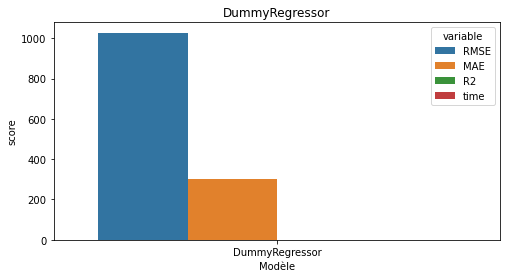

In [24]:
#
plt.figure(figsize=(8,4))
sns.barplot(x = Baseline['Modèle'],
            y = Baseline['score'], hue = Baseline['variable'])
plt.title('DummyRegressor')

In [25]:
# Nous allons donc réaliser nos premières modélisations :
# 3.Prédiction des émissions de CO2 (TotalGHGEmissions)
# 3-1 Modèle ElasticNet ('TotalGHGEmissions').
# Paramèttres du modèle.
parameters = {'tol' : [0.1,0.01,0.001,0.0001],  #critères d'arrêt
              # arrêt de rechercher un minimum (ou un maximum) une fois qu'une certaine tolérance est atteinte 
              "alpha": [0.001, 10, 0.1], 
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}  
# GridSearchCV du modèle.
elastic_grid = GridSearchCV(estimator = ElasticNet(random_state= 42), 
                            param_grid = parameters,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, #  le nombre de processus (tous les processeurs seront utilisés)
                            cv=5,
                            verbose=0
                            )

In [26]:
# Estimation du modèle.
elastic_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.001, 10, 0.1],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_root_mean_squared_error')

In [27]:
# Edition des meilleurs paramètres estimés.
elastic_grid.best_params_

{'alpha': 10, 'l1_ratio': 0.8, 'tol': 0.1}

In [28]:
# l1_ratio est de 0.80, signifiant que le poids du L2 est plus important que celui du L1 dans la régularisation
# 'Alpha’ : 0.001, donc, une régression Ridge est préféré.

In [29]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
emissions_CO2 = pd.DataFrame({})
rmse = mean_squared_error(y_test, elastic_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, elastic_grid.predict(X_test))
r_squared = r2_score(y_test, elastic_grid.predict(X_test))
time = %timeit -o elastic_grid.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['ElasticNet'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                'Cv_score(RMSE)': -1 * elastic_grid.best_score_}),
                         ignore_index=True)

3 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
# Visualisation.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507


Text(0.5, 1.0, 'coefficients de Elastic_Net')

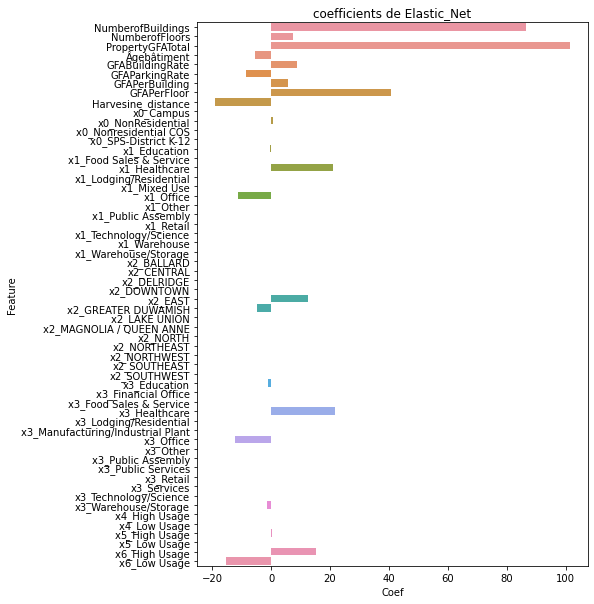

In [31]:
# Coefficients de regression du modèle Elastic_Net.
elastic_Coef=pd.DataFrame({'Feature': X_test.columns,
              'Coef': elastic_grid.best_estimator_.coef_})
plt.figure(figsize=(7,10))
sns.barplot(x = elastic_Coef['Coef'],
            y = elastic_Coef['Feature'])
plt.title('coefficients de Elastic_Net')

In [32]:
# 3.2.Modèle Support Vector Machine (SVM) - (TotalGHGEmissions).
# Paramètres du modèle.
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], # distance pour calcul de la ligne de séparation plausible
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10, 100]} # parametre de régularisation(le paramètre de pénalité)

# GridSearch du modèle.
svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1,
                      cv=5,
                      verbose=5
                     )
# Estimation du modèle.
svm.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [33]:
# Edition des meilleurs paramètres estimés.
svm.best_params_

{'C': 100, 'epsilon': 1, 'gamma': 0.01}

In [34]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
rmse = mean_squared_error(y_test, svm.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, svm.predict(X_test))
r_squared = r2_score(y_test, svm.predict(X_test))
time = %timeit -o  svm.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['SVR'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * svm.best_score_}),
                         ignore_index=True)

66.8 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
# Visualisation.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507
1,SVR,1001.918245,202.630339,0.047476,63.711500,595.740600


In [36]:
# 3.3. Modèle Random Forest Regressor (TotalGHGEmissions).
# Paramètres du modèle.
parameters = {
    'n_estimators' : [100, 300, 500],  #nombre d'arbres de décision
    'min_samples_leaf' : [1, 2, 5], 
    #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] 
    #nombre de features observées par arbre
}
# GridSearchCV du modèle.
R_Forest_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                        param_grid=parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=5,
                        cv=5)
# Estimation du modèle.
R_Forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [37]:
# Edition des meilleurs paramètres estimés.
R_Forest_grid.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}

In [38]:
# Coefficients de regression du modèle RandomForestRegressor.
coefficients = abs(R_Forest_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

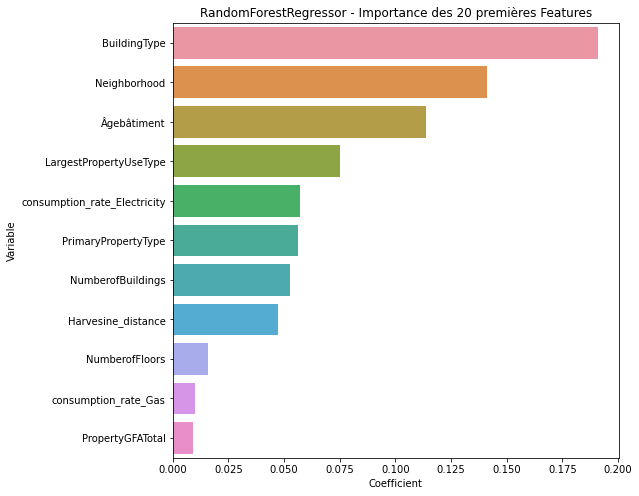

In [39]:
# Importance des features.
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [40]:
#
R_Forest_grid.best_score_

-474.74099720704726

In [41]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
rmse = mean_squared_error(y_test, R_Forest_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, R_Forest_grid.predict(X_test))
r_squared = r2_score(y_test, R_Forest_grid.predict(X_test))
time = %timeit -o  R_Forest_grid.best_estimator_.predict(X_test)
emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['Random Forest Regressor'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * R_Forest_grid.best_score_}),
                         ignore_index=True)

31.5 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507
1,SVR,1001.918245,202.630339,0.047476,63.711500,595.740600
2,Random Forest Regressor,928.964563,184.051244,0.181140,24.847160,474.740997


In [43]:
# 3.4.Modèle XGBoost (TotalGHGEmissions).
# Paramètres du modèle.
parameters = {
    'loss': ['ls', 'lad'],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [1, 2, 5, 8, 12],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['mse'],
}
# GridSearchCV du modèle.
xgb_grid = GridSearchCV(GradientBoostingRegressor(random_state= 42),
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = -1,
                        cv = 5,
                        verbose=5)
# Estimation du modèle.
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'loss': ['ls', 'lad'],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 8, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [44]:
# Edition des meilleurs paramètres estimés.
xgb_grid.best_params_

{'criterion': 'mse',
 'loss': 'ls',
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'n_estimators': 300}

In [45]:
# Coefficients de regression du modèle XGBoost.
coefficients = abs(xgb_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

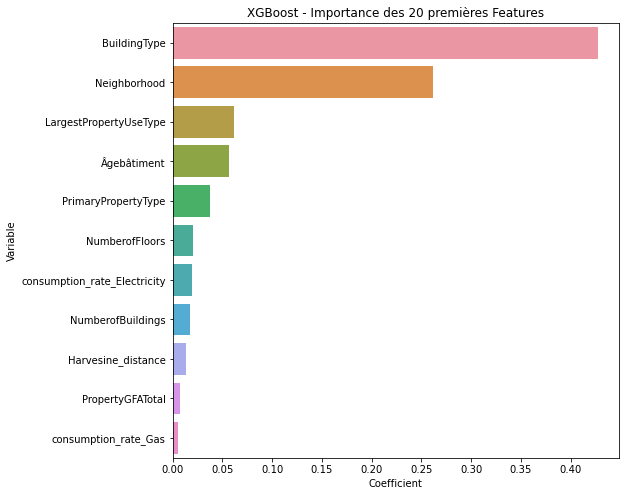

In [46]:
# Importance des features.
plt.figure(figsize=(8,8))
plt.title('XGBoost - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [47]:
# Edition du meilleur score des estimations du modèle.
xgb_grid.best_score_

-447.22082756853086

In [48]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
rmse = mean_squared_error(y_test, xgb_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, xgb_grid.predict(X_test))
r_squared = r2_score(y_test, xgb_grid.predict(X_test))
time = %timeit -o  xgb_grid.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['XGBoost'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * xgb_grid.best_score_}),
                         ignore_index=True)

6.12 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
# Visualisation.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507
1,SVR,1001.918245,202.630339,0.047476,63.711500,595.740600
2,Random Forest Regressor,928.964563,184.051244,0.181140,24.847160,474.740997
3,XGBoost,952.369380,200.670501,0.139358,5.175507,447.220828


In [50]:
# Tri des resultats par ordre décroissant par rapport à R^2.
emissions_CO2 = emissions_CO2.sort_values(by='R²', ascending=False)
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
2,Random Forest Regressor,928.964563,184.051244,0.181140,24.847160,474.740997
3,XGBoost,952.369380,200.670501,0.139358,5.175507,447.220828
0,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507
1,SVR,1001.918245,202.630339,0.047476,63.711500,595.740600


In [51]:
# Le meilleur modèle choisi: Random Forest Regressor. Mais le modèle XGBoost présente le meilleur compromis résultats/temps.
# Nous allons choisir XGBoost, comme le meilleur modèle de prédiction de la consommation d’Energie.

In [52]:
# Comparation des différents modèles.
#comparaison1 = pd.melt(consommation_energy.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²"])
comparaison = pd.melt(emissions_CO2.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²","Time_ms"])

Text(0.5, 1.0, 'Comparaison des performances des modèles')

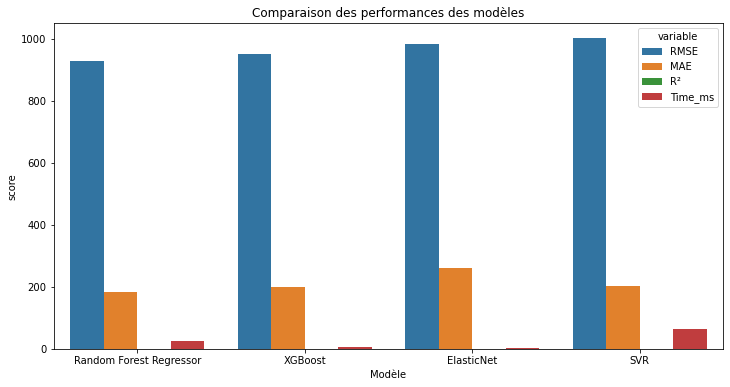

In [53]:
# Représentation graphique de la comparation des différents modèles.
plt.figure(figsize=(12,6))
sns.barplot(x = comparaison['Modèle'],
            y = comparaison['score'], hue = comparaison['variable'])
plt.title('Comparaison des performances des modèles')

In [54]:
#
R_Forest_grid.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}

In [55]:
# sauvegarde les paramètres de meilleur modèle.
best_param = R_Forest_grid.best_params_
for i in best_param:
  best_param[i] = list([best_param[i]])

joblib.dump(best_param, 'best_param_rfr_CO2.sav')

['best_param_rfr_CO2.sav']

In [56]:
# 5.Influence de la variable 'ENERGY STAR Score. 
# Nous cherchons en particulier à évaluer l'intérêt de l’'ENERGY STAR Score' (www.energystar.gov) pour la prédiction de la consommation totale de l'énergie, qui est fastidieux à calculer avec l’approche utilisée actuellement par l'équipe.
# Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.
X_enS = X.copy()

In [57]:
# Ajout de 'ENERGYSTARScore' aux variables X.
X_enS['energy_star_score'] = energy_star_score

In [58]:
# Variables cibles:Target variables.
y_enS = data_clean[['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','SiteEnergyUseWN(kBtu)_log','TotalGHGEmissions_log']]

In [60]:
# Ajout de la colonne (variable) ENERGYSTARScore.
col_names = ['energy_star_score']
features = X_enS[col_names]

In [61]:
# Les variables catégorielles.
category_enS_columns = X_enS.select_dtypes(exclude = ['int64','float64']).columns
# Visualisation.
category_enS_columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'consumption_rate_Electricity',
       'consumption_rate_Gas', 'consumption_rate_Steam'],
      dtype='object')

In [62]:
# Matrice des variables numériques.
numeric_enS_columns = X_enS.select_dtypes(include = ['int64','float64']).columns
# Visualisation.
numeric_enS_columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'Âgebâtiment', 'GFABuildingRate', 'GFAParkingRate', 'GFAPerBuilding',
       'GFAPerFloor', 'Harvesine_distance', 'energy_star_score'],
      dtype='object')

In [63]:
# Séparation du dataset en train et test datasets avec cible sans Log.
X_enS_train, X_enS_test, y_enS_train, y_enS_test = train_test_split(X_enS,y_enS['TotalGHGEmissions'], test_size=0.30, random_state=42)
# Edition de la taille du Train, du Test dataset, et du nombre des features.
print('Nombre d\'individus dans le Train Set :',len(X_enS_train), '\nNombre d\'individus dans le Test Set :',len(X_enS_test),'\nNombre de features :',len(X_enS_train.columns))

Nombre d'individus dans le Train Set : 759 
Nombre d'individus dans le Test Set : 326 
Nombre de features : 17


In [64]:
# Réinitialisation du train dataset.
X_enS_train = X_enS_train.reset_index(drop=True)
y_enS_train = y_enS_train.reset_index(drop=True)
# Réintialisation du set dataset.
X_enS_test = X_enS_test.reset_index(drop=True)
y_enS_test = y_enS_test.reset_index(drop=True)

In [65]:
# Normalisation des datasets X_train et X_test.
scaler = StandardScaler()
# Fit transformation.
std_scale  = scaler.fit(X_enS_train[numeric_enS_columns])
# Normalisation de X_train dataset
X_enS_train[numeric_enS_columns] = std_scale.transform(X_enS_train[numeric_enS_columns])
# Normalisation de X_test dataset
X_enS_test[numeric_enS_columns]  = std_scale.transform(X_enS_test[numeric_enS_columns])

In [66]:
# Transformation des variables catégorielles en variables numériques par l'usage de One-hot-encoding.
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Transformation des variables catégorielles de X_train en variables numériques.
df_enS_train = pd.DataFrame(data=encoder.fit_transform(X_enS_train[category_enS_columns]),
                                      columns=encoder.get_feature_names())
# Transformation des variables catégorielles de X_test en variables numériques.
df_enS_test  = encoder.transform(X_enS_test[category_enS_columns])
df_enS_test  = pd.DataFrame(data=df_enS_test,columns=encoder.get_feature_names())

In [67]:
# Maintenant que les variables numériques et catégoriques sont prêtes, nous allons les mettre ensemble
# 1.2.4. Fusionner les variables numériques et catégoriques de X_train.
X_enS_train = pd.concat([X_enS_train[numeric_enS_columns], df_enS_train], axis=1)
# 1.2.4. Fusionner les variables numériques et catégoriques de X_test.
X_enS_test = pd.concat([X_enS_test[numeric_enS_columns], df_enS_test], axis=1)

In [68]:
X_enS_train.shape

(759, 59)

In [69]:
X_enS_test.shape

(326, 59)

In [70]:
# On utilise ici le meilleur modèle calculé sur la variable 'TotalGHGEmissions' en incluant l'ENERGY STAR Score :
parameters = {
    'n_estimators' : [100, 300, 500],  #nombre d'arbres de décision
    'min_samples_leaf' : [1, 2, 5], 
    #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] 
    #nombre de features observées par arbre
}
    
R_Forest_grid_star_enS = GridSearchCV(RandomForestRegressor(random_state=42),
                        param_grid=parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=5,
                        cv=5)                    
                    
R_Forest_grid_star_enS.fit(X_enS_train, y_enS_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [71]:
#
coefficients = abs(R_Forest_grid_star_enS.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X_enS.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

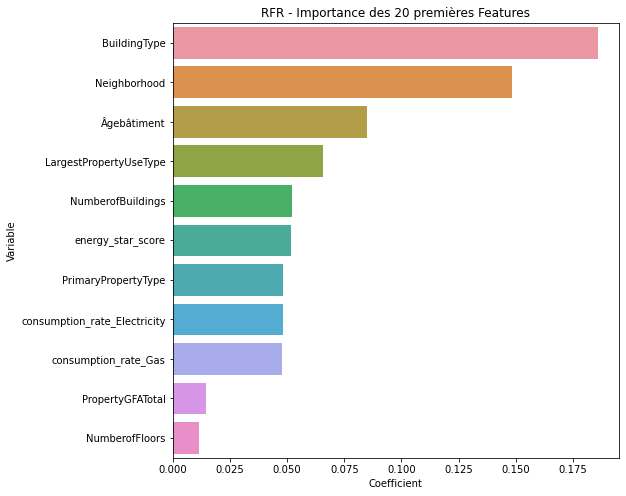

In [72]:
#
plt.figure(figsize=(8,8))
plt.title('RFR - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [73]:
#
Energy_Star = pd.DataFrame({})

rmse = mean_squared_error(y_enS_test, R_Forest_grid_star_enS.predict(X_enS_test), squared=False)
mae = mean_absolute_error(y_enS_test, R_Forest_grid_star_enS.predict(X_enS_test))
r_squared = r2_score(y_enS_test, R_Forest_grid_star_enS.predict(X_enS_test))
time = %timeit -o  R_Forest_grid_star_enS.best_estimator_.predict(X_enS_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['Random Forest Regressor_Star'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * R_Forest_grid_star_enS.best_score_}),
                         ignore_index=True)

29.1 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,Random Forest Regressor,928.964563,184.051244,0.181140,24.847160,474.740997
1,XGBoost,952.369380,200.670501,0.139358,5.175507,447.220828
2,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507
3,SVR,1001.918245,202.630339,0.047476,63.711500,595.740600
4,Random Forest Regressor_Star,919.520248,180.440268,0.197705,25.748400,479.853113


In [75]:
#
emissions_CO2 = emissions_CO2.sort_values(by='R²', ascending=False)
# Visualisation des résultats globaux.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
4,Random Forest Regressor_Star,919.520248,180.440268,0.197705,25.748400,479.853113
0,Random Forest Regressor,928.964563,184.051244,0.181140,24.847160,474.740997
1,XGBoost,952.369380,200.670501,0.139358,5.175507,447.220828
2,ElasticNet,981.885971,260.366935,0.085184,2.777004,589.069507
3,SVR,1001.918245,202.630339,0.047476,63.711500,595.740600


In [76]:
# En ajoutant EnergyStarScore à notre modèle, la performance du modèle s'améliore très légèrement.

In [77]:
# Comparation des différents modèles.
comparaison = pd.melt(emissions_CO2.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²","Time_ms"])

Text(0.5, 1.0, 'Comparaison des performances des modèles')

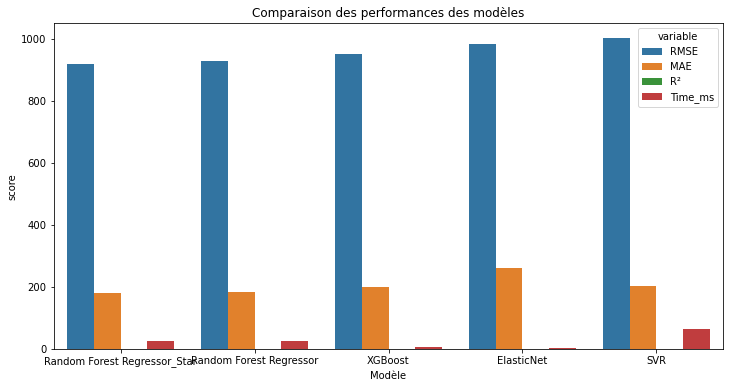

In [78]:
# Représentation graphique de la comparation des différents modèles.
plt.figure(figsize=(12,6))
sns.barplot(x = comparaison['Modèle'],
            y = comparaison['score'], hue = comparaison['variable'])
plt.title('Comparaison des performances des modèles')

In [79]:
# Examin du modèle avec la transformation log.
# Séparation du dataset en train et test datasets.
X_train, X_test, y_train, y_test = train_test_split(X,y['TotalGHGEmissions_log'], test_size=0.30, random_state=42)
# Edition de la taille du Train, du Test dataset, et du nombre des features.
print('Nombre d\'individus dans le Train Set :',len(X_train), '\nNombre d\'individus dans le Test Set :',len(X_test),'\nNombre de features :',len(X_train.columns))

Nombre d'individus dans le Train Set : 759 
Nombre d'individus dans le Test Set : 326 
Nombre de features : 16


In [80]:
# Réinitialisation du train dataset.
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
# Réintialisation du set dataset.
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [81]:
# Normalisation des datasets X_train et X_test.
scaler = StandardScaler()
# Fit transformation.
std_scale  = scaler.fit(X_train[numeric_columns])
# Normalisation de X_train dataset
X_train[numeric_columns] = std_scale.transform(X_train[numeric_columns])
# Normalisation de X_test dataset
X_test[numeric_columns]  = std_scale.transform(X_test[numeric_columns])

In [82]:
# Transformation des variables catégorielles en variables numériques par l'usage de One-hot-encoding.
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Transformation des variables catégorielles de X_train en variables numériques.
df_train = pd.DataFrame(data=encoder.fit_transform(X_train[category_columns]),
                                      columns=encoder.get_feature_names())
# Transformation des variables catégorielles de X_test en variables numériques.
df_test  = encoder.transform(X_test[category_columns])
df_test  = pd.DataFrame(data=df_test,columns=encoder.get_feature_names())

In [83]:
# Maintenant que les variables numériques et catégoriques sont prêtes, nous allons les mettre ensemble
# 1.2.4. Fusionner les variables numériques et catégoriques de X_train.
X_train = pd.concat([X_train[numeric_columns], df_train], axis=1)
# 1.2.4. Fusionner les variables numériques et catégoriques de X_test.
X_test = pd.concat([X_test[numeric_columns], df_test], axis=1)

In [84]:
# Baseline model: Dummyregressor.
dummy_regr = DummyRegressor(strategy="mean")
# Entrainement
dummy_regr.fit(X_train,  y_train)

DummyRegressor()

In [85]:
# Prédiction sur le jeu de test
y_test_pred= dummy_regr.predict(X_test)
# evaluation
Results = pd.DataFrame({})
rmse=metrics.mean_squared_error(y_test, y_test_pred, squared = False)
mae=metrics.mean_absolute_error(y_test, y_test_pred)
r2=metrics.r2_score(y_test, y_test_pred)
time = timeit.default_timer() - start_time
Results = Results.append({
    "Modèle" : "DummyRegressor",
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "time": time
}, ignore_index = True)
Results

,MAE,Modèle,R2,RMSE,time
0,0.875001,DummyRegressor,-0.000661,1.095931,624.641119


In [86]:
# 3-1 3.1.Modèle ElasticNet ('TotalGHGEmissions_log'). 
# Paramèttres du modèle.
parameters = {'tol' : [0.1,0.01,0.001,0.0001],  #critères d'arrêt
              # arrêt de rechercher un minimum (ou un maximum) une fois qu'une certaine tolérance est atteinte 
              "alpha": [0.001, 10, 0.1], 
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}  
# GridSearchCV du modèle.
elastic_grid = GridSearchCV(estimator = ElasticNet(random_state= 42), 
                            param_grid = parameters,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, #  le nombre de processus (tous les processeurs seront utilisés)
                            cv=5,
                            verbose=0
                            )

In [87]:
# Estimation du modèle.
elastic_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.001, 10, 0.1],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_root_mean_squared_error')

In [88]:
# Edition des meilleurs paramètres estimés.
elastic_grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.1}

In [89]:
# l1_ratio est de 0.90, signifiant que le poids du L2 est plus important que celui du L1 dans la régularisation
# 'Alpha’ : 0.001, donc, une régression Ridge est préféré.

In [90]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
emissions_CO2 = pd.DataFrame({})
rmse = mean_squared_error(y_test, elastic_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, elastic_grid.predict(X_test))
r_squared = r2_score(y_test, elastic_grid.predict(X_test))
time = %timeit -o elastic_grid.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['ElasticNet'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                'Cv_score(RMSE)': -1 * elastic_grid.best_score_}),
                         ignore_index=True)

3.41 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272


Text(0.5, 1.0, 'coefficients de Elastic_Net')

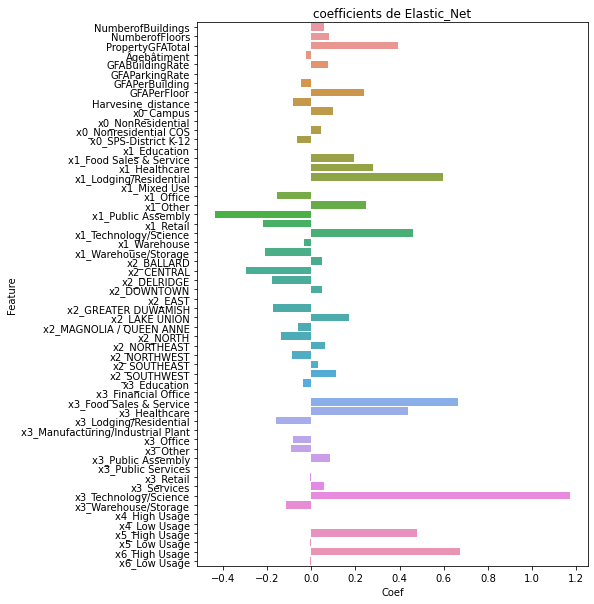

In [92]:
# Coefficients de Elastic_Net.
elastic_Coef=pd.DataFrame({'Feature': X_test.columns,
              'Coef': elastic_grid.best_estimator_.coef_})
plt.figure(figsize=(7,10))
sns.barplot(x = elastic_Coef['Coef'],
            y = elastic_Coef['Feature'])
plt.title('coefficients de Elastic_Net')

In [93]:
# 3.2.Modèle Support Vector Machine (SVM) - (TotalGHGEmissions_log).
# Paramètres du modèle.
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], # distance pour calcul de la ligne de séparation plausible
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10, 100]} # parametre de régularisation(le paramètre de pénalité)
# GridSearch du modèle.
svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1,
                      cv=5,
                      verbose=5
                     )
# Estimation du modèle.
svm.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [94]:
# Edition des meilleurs paramètres estimés.
svm.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}

In [95]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
rmse = mean_squared_error(y_test, svm.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, svm.predict(X_test))
r_squared = r2_score(y_test, svm.predict(X_test))
time = %timeit -o  svm.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['SVR'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * svm.best_score_}),
                         ignore_index=True)

57.5 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
# Visualisation.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272
1,SVR,0.702041,0.520150,0.589375,55.711240,0.635733


In [97]:
# 3.3. Modèle Random Forest Regressor (TotalGHGEmissions_log).
# Paramètres du modèle.
parameters = {
    'n_estimators' : [100, 300, 500],  #nombre d'arbres de décision
    'min_samples_leaf' : [1, 2, 5], 
    #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] 
    #nombre de features observées par arbre
}
# GridSearchCV du modèle.
R_Forest_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                        param_grid=parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=5,
                        cv=5)
# Estimation du modèle.
R_Forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [98]:
# Edition des meilleurs paramètres estimés.
R_Forest_grid.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}

In [99]:
# Coefficients de regression du modèle RandomForestRegressor.
coefficients = abs(R_Forest_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

<AxesSubplot:title={'center':'RandomForestRegressor - Importance des 20 premières Features'}, xlabel='Coefficient', ylabel='Variable'>

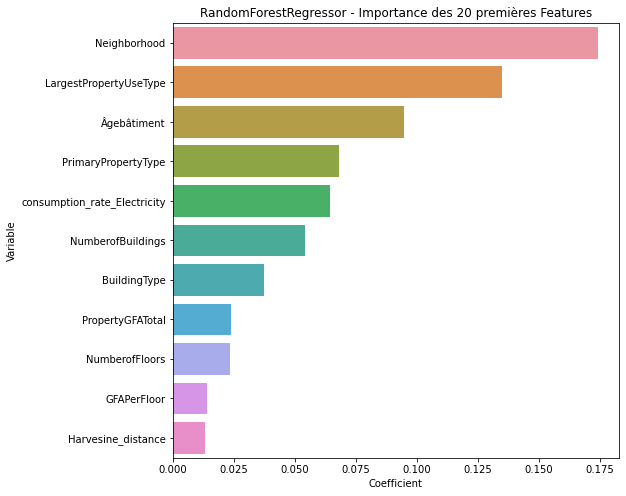

In [100]:
# Importance des features.
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))


In [101]:
#
R_Forest_grid.best_score_

-0.6545988727789848

In [102]:
# Résultats des metrics nécessaires pour le choix du meilleurs modèle.
rmse = mean_squared_error(y_test, R_Forest_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, R_Forest_grid.predict(X_test))
r_squared = r2_score(y_test, R_Forest_grid.predict(X_test))
time = %timeit -o  R_Forest_grid.best_estimator_.predict(X_test)
emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['Random Forest Regressor'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * R_Forest_grid.best_score_}),
                         ignore_index=True)

117 ms ± 5.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272
1,SVR,0.702041,0.520150,0.589375,55.711240,0.635733
2,Random Forest Regressor,0.717954,0.558926,0.570549,112.216850,0.654599


In [104]:
# 3.4.Modèle XGBoost (TotalGHGEmissions_log).
# Paramètres du modèle.
parameters = {
    'loss': ['ls', 'lad'],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [1, 2, 5, 8, 12],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['mse'],
}
# GridSearchCV du modèle.
xgb_grid = GridSearchCV(GradientBoostingRegressor(random_state= 42),
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = -1,
                        cv = 5,
                        verbose=5)
# Estimation du modèle.
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'loss': ['ls', 'lad'],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 8, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [105]:
# Edition des meilleurs paramètres estimés.
xgb_grid.best_params_

{'criterion': 'mse',
 'loss': 'ls',
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'n_estimators': 200}

In [106]:
# Coefficients de regression du modèle XGBoost.
coefficients = abs(xgb_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

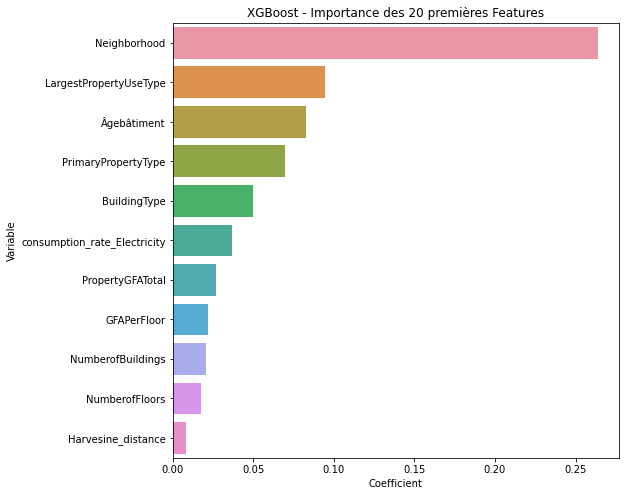

In [107]:
# Importance des features.
plt.figure(figsize=(8,8))
plt.title('XGBoost - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [108]:
#
xgb_grid.best_score_

-0.6273039561902152

In [109]:
#
rmse = mean_squared_error(y_test, xgb_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, xgb_grid.predict(X_test))
r_squared = r2_score(y_test, xgb_grid.predict(X_test))
time = %timeit -o  xgb_grid.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['XGBoost'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * xgb_grid.best_score_}),
                         ignore_index=True)

5.02 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
# Visualisation.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272
1,SVR,0.702041,0.520150,0.589375,55.711240,0.635733
2,Random Forest Regressor,0.717954,0.558926,0.570549,112.216850,0.654599
3,XGBoost,0.668200,0.516893,0.628008,4.496203,0.627304


In [111]:
#
emissions_CO2 = emissions_CO2.sort_values(by='R²', ascending=False)
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
3,XGBoost,0.668200,0.516893,0.628008,4.496203,0.627304
1,SVR,0.702041,0.520150,0.589375,55.711240,0.635733
2,Random Forest Regressor,0.717954,0.558926,0.570549,112.216850,0.654599
0,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272


In [112]:
# Le meilleur modèle choisi: XGBoost.
# Nous allons choisir XGBoost, comme le meilleur modèle de prédiction des émissions de CO2.

In [113]:
# Comparation des différents modèles.
comparaison = pd.melt(emissions_CO2.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²","Time_ms"])

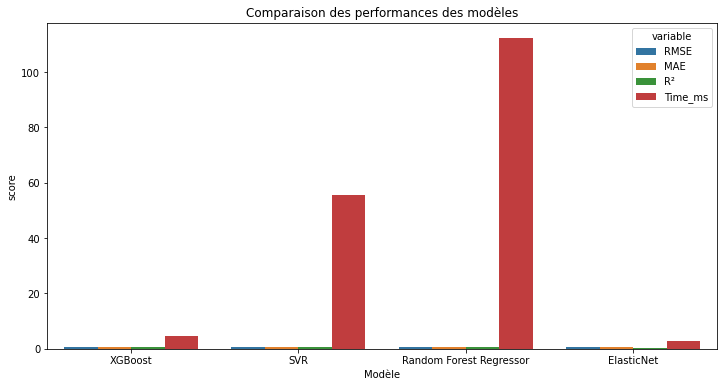

In [114]:
# Représentation graphique de la comparation des différents modèles.
plt.figure(figsize=(12,6))
sns.barplot(x = comparaison['Modèle'],
            y = comparaison['score'], hue = comparaison['variable'])
plt.title('Comparaison des performances des modèles')
plt.savefig('GRAPHS/26- XGBoost')
plt.show()

In [115]:
#
xgb_grid.best_params_

{'criterion': 'mse',
 'loss': 'ls',
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'n_estimators': 200}

In [116]:
# sauvegarde les paramètres de meilleur modèle.
best_param = xgb_grid.best_params_
for i in best_param:
  best_param[i] = list([best_param[i]])

joblib.dump(best_param, 'best_param_xgb_CO2.sav')

['best_param_xgb_CO2.sav']

In [117]:
# 5.Influence de la variable 'ENERGY STAR Score. 
# Nous cherchons en particulier à évaluer l'intérêt de l’'ENERGY STAR Score' (www.energystar.gov) pour la prédiction de la consommation totale de l'énergie, qui est fastidieux à calculer avec l’approche utilisée actuellement par l'équipe.
# Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.
X_enS = X.copy()

In [118]:
# Ajout de 'ENERGYSTARScore' aux variables X.
X_enS['energy_star_score'] = energy_star_score

In [119]:
# Variables cicles.
y_enS = data_clean[['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','SiteEnergyUseWN(kBtu)_log','TotalGHGEmissions_log']]

In [120]:
# Ajout de 'ENERGYSTARScore' aux variables X.
X_enS['energy_star_score'] = energy_star_score

In [121]:
# Ajout de la colonne (variable) ENERGYSTARScore.
col_names = ['energy_star_score']
features = X_enS[col_names]

In [122]:
# Séparation du dataset en train et test datasets avec cible sans Log.
X_enS_train, X_enS_test, y_enS_train, y_enS_test = train_test_split(X_enS,y_enS['TotalGHGEmissions_log'], test_size=0.30, random_state=42)
# Edition de la taille du Train, du Test dataset, et du nombre des features.
print('Nombre d\'individus dans le Train Set :',len(X_enS_train), '\nNombre d\'individus dans le Test Set :',len(X_enS_test),'\nNombre de features :',len(X_enS_train.columns))

Nombre d'individus dans le Train Set : 759 
Nombre d'individus dans le Test Set : 326 
Nombre de features : 17


In [123]:
# Réinitialisation du train dataset.
X_enS_train = X_enS_train.reset_index(drop=True)
y_enS_train = y_enS_train.reset_index(drop=True)
# Réintialisation du set dataset.
X_enS_test = X_enS_test.reset_index(drop=True)
y_enS_test = y_enS_test.reset_index(drop=True)

In [124]:
# Normalisation des datasets X_train et X_test.
scaler = StandardScaler()
# Fit transformation.
std_scale  = scaler.fit(X_enS_train[numeric_enS_columns])
# Normalisation de X_train dataset
X_enS_train[numeric_enS_columns] = std_scale.transform(X_enS_train[numeric_enS_columns])
# Normalisation de X_test dataset
X_enS_test[numeric_enS_columns]  = std_scale.transform(X_enS_test[numeric_enS_columns])

In [125]:
# Transformation des variables catégorielles en variables numériques par l'usage de One-hot-encoding.
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Transformation des variables catégorielles de X_train en variables numériques.
df_enS_train = pd.DataFrame(data=encoder.fit_transform(X_enS_train[category_enS_columns]),
                                      columns=encoder.get_feature_names())
# Transformation des variables catégorielles de X_test en variables numériques.
df_enS_test  = encoder.transform(X_enS_test[category_enS_columns])
df_enS_test  = pd.DataFrame(data=df_enS_test,columns=encoder.get_feature_names())

In [126]:
# Maintenant que les variables numériques et catégoriques sont prêtes, nous allons les mettre ensemble
# 1.2.4. Fusionner les variables numériques et catégoriques de X_train.
X_enS_train = pd.concat([X_enS_train[numeric_enS_columns], df_enS_train], axis=1)
# 1.2.4. Fusionner les variables numériques et catégoriques de X_test.
X_enS_test = pd.concat([X_enS_test[numeric_enS_columns], df_enS_test], axis=1)

In [127]:
X_enS_train.shape

(759, 59)

In [128]:
X_enS_test.shape

(326, 59)

In [129]:
# On utilise ici le meilleur modèle calculé sur la variable TotalGHGEmissions_log en incluant l'ENERGY STAR Score :

Parameters = {
    'loss': ['ls'],
    'n_estimators': [200],
    'min_samples_leaf': [8],
    'max_features': ['sqrt'],
    'criterion': ['mse'],
}

xgb_grid_star_enS = GridSearchCV(GradientBoostingRegressor(random_state=42),
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = -1,
                        cv = 5,
                        verbose=5)

xgb_grid_star_enS.fit(X_enS_train, y_enS_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'loss': ['ls', 'lad'],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 8, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [130]:
#
coefficients = abs(xgb_grid_star_enS.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X_enS.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

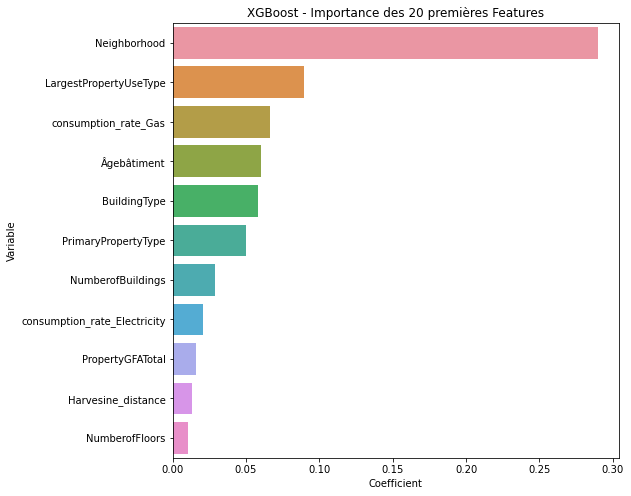

In [131]:
#
plt.figure(figsize=(8,8))
plt.title('XGBoost - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [132]:
#
Energy_Star = pd.DataFrame({})

rmse = mean_squared_error(y_enS_test, xgb_grid_star_enS.predict(X_enS_test), squared=False)
mae = mean_absolute_error(y_enS_test, xgb_grid_star_enS.predict(X_enS_test))
r_squared = r2_score(y_enS_test, xgb_grid_star_enS.predict(X_enS_test))
time = %timeit -o  xgb_grid_star_enS.best_estimator_.predict(X_enS_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['XGBoost_Star'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * xgb_grid_star_enS.best_score_}),
                         ignore_index=True)

5.03 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [133]:
# Visualisation des résultats.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,XGBoost,0.668200,0.516893,0.628008,4.496203,0.627304
1,SVR,0.702041,0.520150,0.589375,55.711240,0.635733
2,Random Forest Regressor,0.717954,0.558926,0.570549,112.216850,0.654599
3,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272
4,XGBoost_Star,0.638964,0.488974,0.659847,4.569752,0.599932


In [134]:
#
emissions_CO2 = emissions_CO2.sort_values(by='R²', ascending=False)
# Visualisation des résultats globaux.
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
4,XGBoost_Star,0.638964,0.488974,0.659847,4.569752,0.599932
0,XGBoost,0.668200,0.516893,0.628008,4.496203,0.627304
1,SVR,0.702041,0.520150,0.589375,55.711240,0.635733
2,Random Forest Regressor,0.717954,0.558926,0.570549,112.216850,0.654599
3,ElasticNet,0.819082,0.587439,0.441047,2.854866,0.709272


In [135]:
# En ajoutant Energy Star Score à notre modèle, la performance du modèle s'améliore très légèrement.

In [136]:
# Comparation des différents modèles.
comparaison = pd.melt(emissions_CO2.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²","Time_ms"])

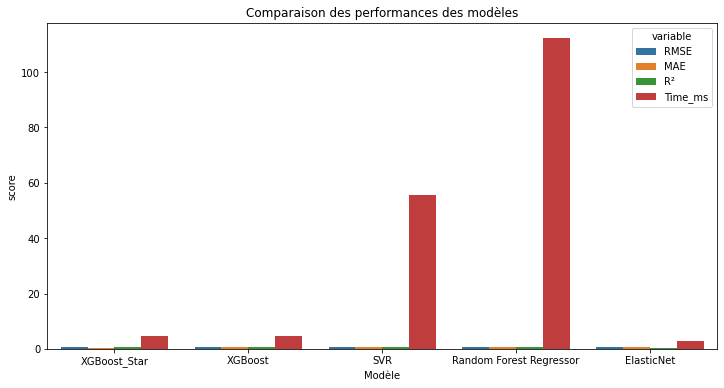

In [137]:
# Représentation graphique de la comparation des différents modèles.
plt.figure(figsize=(12,6))
sns.barplot(x = comparaison['Modèle'],
            y = comparaison['score'], hue = comparaison['variable'])
plt.title('Comparaison des performances des modèles')
plt.savefig('GRAPHS/21- XGBoost__EnergyStar')
plt.show()

In [138]:
# Importance des features. 
# train XGBoost model
model = XGBRegressor(**xgb_grid_star_enS.best_params_).fit(X_enS_train, y_enS_train)

[00:33:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "criterion", "loss", "max_features", "min_samples_leaf" } are not used.



In [139]:
# explain the model's predictions using SHAP values.
shap_values = shap.TreeExplainer(model).shap_values(X_enS_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_enS_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


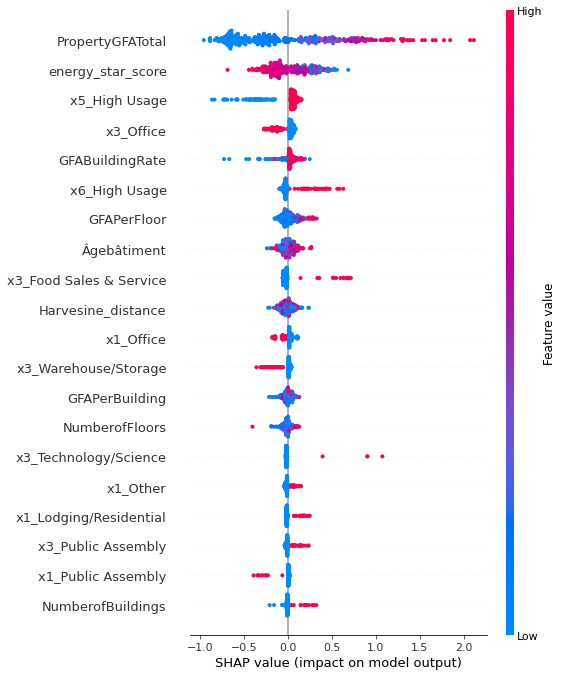

In [140]:
# Distribution de l'importance de chaque feature sur la Cible (Target).
fig=plt.gcf()
shap.summary_plot(shap_values, X_enS_test)
fig.savefig('GRAPHS/scratch.png')
fig.savefig('GRAPHS/test.svg', bbox_inches='tight')

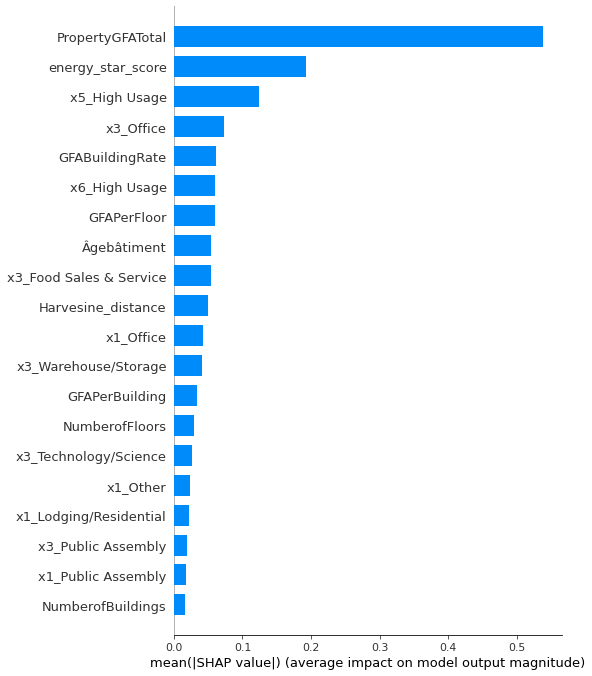

In [141]:
# Impact moyen de chaque feature sur la Cible (target).
fig=plt.gcf()
shap.summary_plot(shap_values, X_enS_test, plot_type="bar")
fig.savefig('scratch.png')
fig.savefig('test.svg', bbox_inches='tight')

In [142]:
# Impact du premier bâtiment sur la consomation de l'énergie dans la ville de Seattle.
shap.initjs()
e3 = shap.TreeExplainer(model)
t = e3.shap_values(X_enS_test)
shap.force_plot(e3.expected_value, shap_values[0,:], np.array(X_enS_test)[0,:])
#f=shap.force_plot(e3.expected_value, shap_values[0,:], np.array(X_enS_test)[0,:], show=False)
#shap.save_html("GRAPHS/index.htm", f)

In [143]:
# Impact des 500 premiers bâtiments sur la consomation de l'énergie dans la ville de Seattle.
shap.initjs()
e3 = shap.TreeExplainer(model)
t = e3.shap_values(X_enS_test)
shap.force_plot(e3.expected_value, shap_values[0:500,:], np.array(X_enS_test)[0:500,:])
#f=shap.force_plot(e3.expected_value, shap_values[0:500,:], np.array(X_enS_test)[0:500,:], show=False)
#shap.save_html("index.htm", f)